In [188]:
# import packages
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool1D, Flatten, Dropout, AveragePooling1D
from keras.layers import Input
from keras.models import Model, Sequential
#from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
import keras
import keras.regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.utils import class_weight
from sklearn.utils import resample
import warnings
import os
warnings.filterwarnings('ignore')

In [189]:
# Parameters

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
EPOCHS = 20
BATCH_SIZE = 16

In [190]:
# load data
df_train=pd.read_csv('src/mitbih_train.csv',header=None)
df_test=pd.read_csv('src/mitbih_test.csv',header=None)

df_train.head()
df_train.tail()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87553,0.901506,0.845886,0.800695,0.748552,0.687138,0.599073,0.512167,0.427578,0.395133,0.402086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [191]:
# Divide train set into train and validation
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)
#df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT)

In [192]:
# Divide sets based on classification (column 187)

df_train_0 = df_train[df_train[187] == 0]
df_train_1 = df_train[df_train[187] == 1]
df_train_2 = df_train[df_train[187] == 2]
df_train_3 = df_train[df_train[187] == 3]
df_train_4 = df_train[df_train[187] == 4]
df_train_0_x = df_train_0.iloc[:,:186].values
df_train_1_x = df_train_1.iloc[:,:186].values
df_train_2_x = df_train_2.iloc[:,:186].values
df_train_3_x = df_train_3.iloc[:,:186].values
df_train_4_x = df_train_4.iloc[:,:186].values

df_valid_0 = df_valid[df_valid[187] == 0]
df_valid_1 = df_valid[df_valid[187] == 1]
df_valid_2 = df_valid[df_valid[187] == 2]
df_valid_3 = df_valid[df_valid[187] == 3]
df_valid_4 = df_valid[df_valid[187] == 4]
df_valid_0_x = df_valid_0.iloc[:,:186].values
df_valid_1_x = df_valid_0.iloc[:,:186].values
df_valid_2_x = df_valid_0.iloc[:,:186].values
df_valid_3_x = df_valid_0.iloc[:,:186].values
df_valid_4_x = df_valid_0.iloc[:,:186].values

df_test_0 = df_test[df_test[187] == 0]
df_test_1 = df_test[df_test[187] == 1]
df_test_2 = df_test[df_test[187] == 2]
df_test_3 = df_test[df_test[187] == 3]
df_test_4 = df_test[df_test[187] == 4]
df_test_0_x = df_test_0.iloc[:,:186].values
df_test_1_x = df_test_0.iloc[:,:186].values
df_test_2_x = df_test_0.iloc[:,:186].values
df_test_3_x = df_test_0.iloc[:,:186].values
df_test_4_x = df_test_0.iloc[:,:186].values

df_train_x = df_train.iloc[:,:186].values
df_valid_x = df_valid.iloc[:,:186].values
df_test_x = df_test.iloc[:,:186].values

In [193]:
# Only use normal samples
#X_train = df_train_0_x.reshape(len(df_train_0_x), df_train_0_x.shape[1],1)
#X_test = df_test_0_x.reshape(len(df_test_0_x), df_test_0_x.shape[1],1)
#X_valid = df_valid_0_x.reshape(len(df_valid_0_x), df_valid_0_x.shape[1],1)

# Use all samples
X_train = df_train_x.reshape(len(df_train_x), df_train_x.shape[1],1)
X_test = df_test_x.reshape(len(df_test_x), df_test_x.shape[1],1)
X_valid = df_valid_x.reshape(len(df_valid_x), df_valid_x.shape[1],1)

In [194]:
input_dim = X_train.shape[1]
encoding_dim = 93
hidden_dim = 47

input_layer = Input(shape=(input_dim, ))
#encoder = Dense(input_dim, activation="relu")(input_layer)
#input_layer = Dense(input_dim, activation="relu")
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dropout(0.2)(encoder)
encoder = Dense(hidden_dim, activation="relu")(encoder)

decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dropout(0.2)(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
#decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 186)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 93)             │        17,391 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 93)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 47)             │         4,418 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 47)             │         2,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 93)             │         4,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 93)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 186)            │        17,484 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,013 (179.74 KB)

 Trainable params: 46,013 (179.74 KB)

 Non-trainable params: 0 (0.00 B)

In [195]:
optimizer = keras.optimizers.Adam(learning_rate=0.00001)

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer=optimizer)

cp = ModelCheckpoint(filepath="./models/autoencoder_classifier.keras",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs/fit/autoencoder',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    #shuffle=True,
                    validation_data=(X_valid, X_valid),
                    verbose=1,
                    callbacks=[cp, tb]).history

Epoch 1/20
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.0629 - loss: 0.0568 - val_accuracy: 0.4028 - val_loss: 0.0217
Epoch 2/20
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.3364 - loss: 0.0250 - val_accuracy: 0.3781 - val_loss: 0.0170
Epoch 3/20
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.3229 - loss: 0.0198 - val_accuracy: 0.3709 - val_loss: 0.0142
Epoch 4/20
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.3355 - loss: 0.0171 - val_accuracy: 0.3760 - val_loss: 0.0129
Epoch 5/20
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.3441 - loss: 0.0156 - val_accuracy: 0.3753 - val_loss: 0.0120
Epoch 6/20
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.3527 - loss: 0.0145 - val_accuracy: 0.3730 - val_loss: 0.0113
Epoch 7/20
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.3574 - loss: 0.0137 - val_accuracy: 0.3725 - val_loss: 0.0108
Epoch 8/20
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.3591 - loss: 0

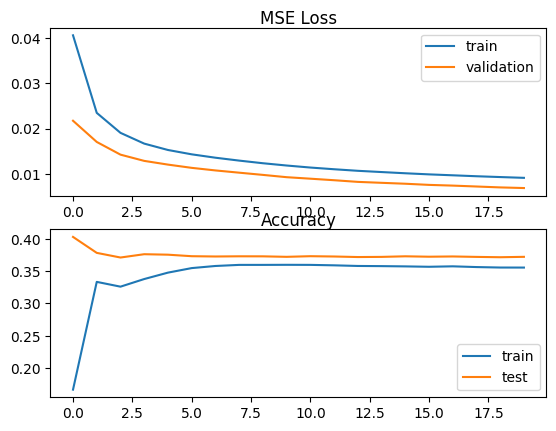

In [196]:
plt.subplot(211)
plt.title('MSE Loss', pad=-40)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.legend()

plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [197]:
# Run model on test data
predictions = autoencoder.predict(X_test)

# Calculate Mean Square Error between test and reconstructed data
mse = np.zeros_like(X_test)
for i in range(len(X_test)):
    mse[i] = mean_squared_error(X_test[i], predictions[i])
mse_avg = np.mean(mse)
print("MSE: " + str(mse_avg))

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MSE: 0.006856249843915712


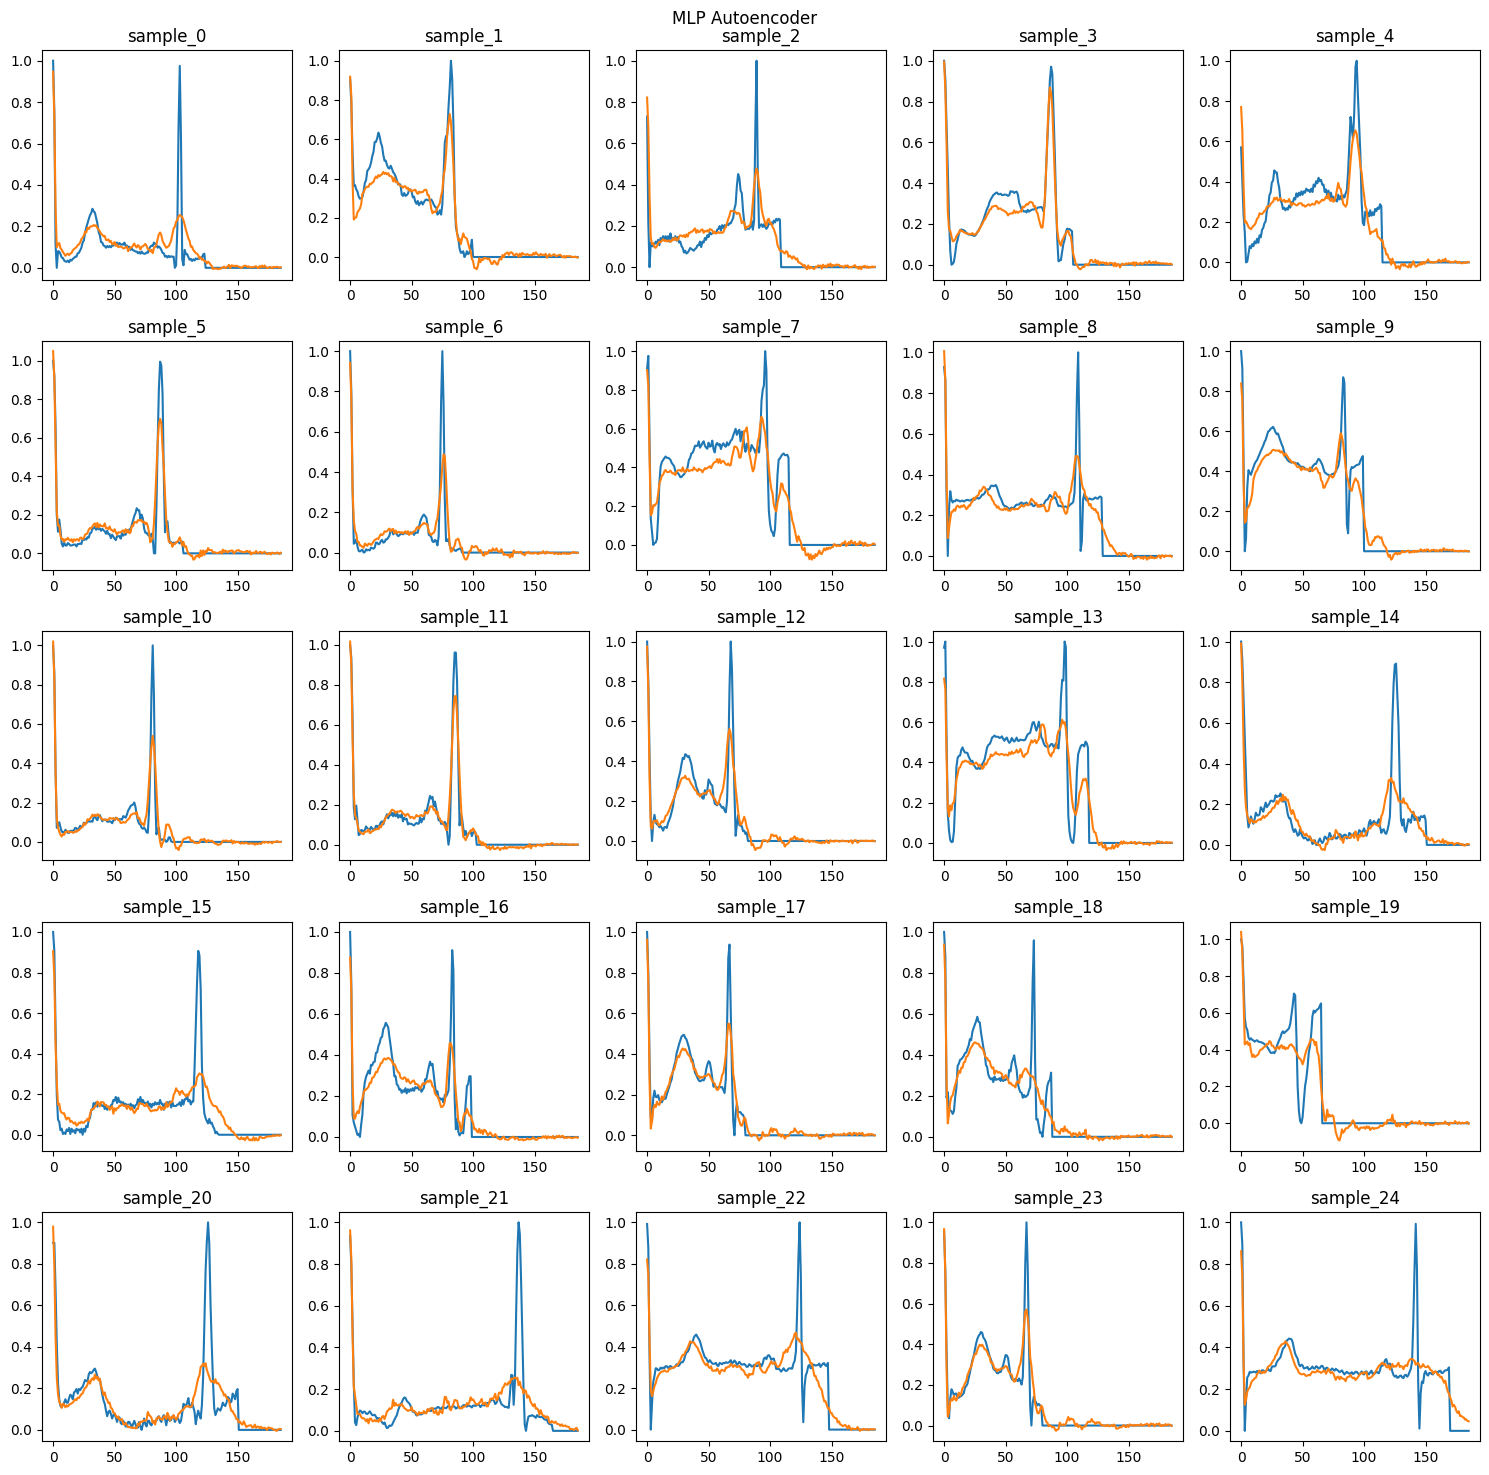

In [198]:
# Plot samples
fig, axs = plt.subplots(5, 5)
fig.set_size_inches(15, 15)
fig.suptitle("MLP Autoencoder")
for i, ax in enumerate(axs.flatten()):
    ax.title.set_text('sample_'+str(i))
    ax.plot(X_test[i])
    ax.plot(predictions[i])
plt.tight_layout()
plt.show()